Load in Data from .mat files

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import get_high_gamma_data

In [2]:
hg_trace, hg_map, phon_labels = get_high_gamma_data('data/S14/S14_HG.mat')

(149, 200, 111)
(149, 8, 16, 200)
(149, 3)


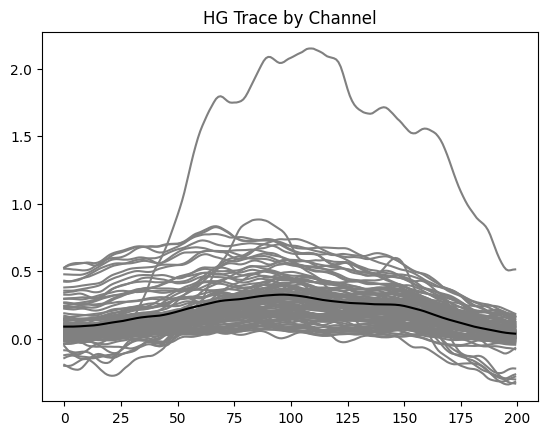

In [3]:
print(hg_trace.shape)
print(hg_map.shape)
print(phon_labels.shape)

plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1/3 D CNN Bidirectional LSTM seq2seq

In [4]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [5]:
# parameters
n_output = 10

In [6]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
X = hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

In [7]:
print(X.shape, X_prior.shape, y.shape, prior_labels.shape, seq_labels.shape)

(149, 8, 16, 200) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [8]:
# imports
from seq2seq_models.rnn_models import (lstm_1Dcnn_model, gru_1Dcnn_model, 
                                       lstm_3Dcnn_model, gru_3Dcnn_model)


In [9]:
# parameters

# 1D CNN
# n_input_time = X.shape[1]
# n_input_channel = X.shape[2]
filter_size = 10

# 3D CNN
n_input_x = X.shape[1]
n_input_y = X.shape[2]
n_input_time = X.shape[3]
filter_size = 2

n_filters = 100
n_units = 800
reg_lambda = 1e-6
bidir = False

In [10]:
# train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = lstm_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
train_model, inf_enc, inf_dec = gru_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [11]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

Model: "training_gru_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 16, 200,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 4, 8, 100, 1  900         ['input_1[0][0]']                
                                00)                                                               
                                                                                                  
 permute (Permute)              (None, 100, 4, 8, 1  0           ['conv3d[0][0]']                 
                                00)                                              

Train Model

In [12]:
# imports
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold

In [32]:
# parameters
num_folds = 10
batch_size = 64
epochs = 500
learning_rate = 1e-5

In [33]:
train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
models, histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X, X_prior, y, num_folds=num_folds, batch_size=batch_size, epochs=epochs)

========== Fold 1 ==========
Epoch 1/500
3/3 [==============================] - 3s 277ms/step - loss: 2.3246 - accuracy: 0.1095 - val_loss: 2.3225 - val_accuracy: 0.0889
Epoch 2/500
3/3 [==============================] - 0s 62ms/step - loss: 2.3136 - accuracy: 0.1269 - val_loss: 2.3150 - val_accuracy: 0.0889
Epoch 3/500
3/3 [==============================] - 0s 62ms/step - loss: 2.3048 - accuracy: 0.1343 - val_loss: 2.3090 - val_accuracy: 0.0667
Epoch 4/500
3/3 [==============================] - 0s 62ms/step - loss: 2.2973 - accuracy: 0.1443 - val_loss: 2.3033 - val_accuracy: 0.0667
Epoch 5/500
3/3 [==============================] - 0s 61ms/step - loss: 2.2900 - accuracy: 0.1443 - val_loss: 2.2980 - val_accuracy: 0.1556
Epoch 6/500
3/3 [==============================] - 0s 66ms/step - loss: 2.2832 - accuracy: 0.1567 - val_loss: 2.2924 - val_accuracy: 0.1778
Epoch 7/500
3/3 [==============================] - 0s 63ms/step - loss: 2.2767 - accuracy: 0.1567 - val_loss: 2.2864 - val_accurac

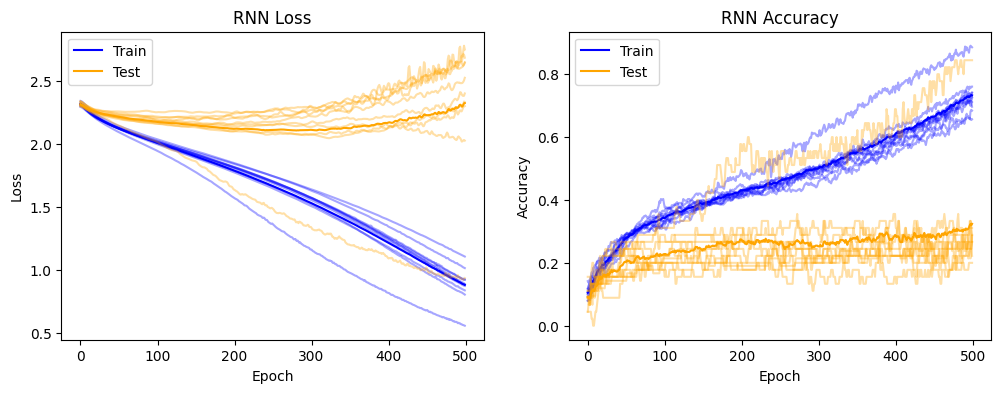

In [35]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame()
keys = list(histories.keys())
for i in range(len(keys)):
    if df.empty:
        df = pd.DataFrame(np.array(histories[keys[i]])).melt()
    else:
        print(keys[i])
        df = pd.concat([df, pd.DataFrame(np.array(histories[keys[i]])).melt()], axis=1)
    df.rename(columns={'value': keys[i]}, inplace=True)
df = df.loc[:,~df.columns.duplicated()].copy()
df.rename(columns={'variable': 'epoch'}, inplace=True)

# df = pd.DataFrame(np.array(histories['loss'])).melt()
# df = df.merge(pd.DataFrame(np.array(histories['val_loss'])).melt(), on='variable', suffixes=('_train', '_val'))
# df = pd.concat([df, pd.DataFrame(np.array(histories['val_loss'])).melt()], axis=1)
print(df.shape)
print(df)


# tr_loss_df = pd.DataFrame(np.array(histories['loss'])).melt()
# val_loss_df = pd.DataFrame(np.array(histories['val_loss'])).melt()
# loss_df = tr_loss_df.merge(val_loss_df, on='variable', suffixes=('_train', '_val'))
# print(loss_df.shape)
# print(loss_df)

loss
val_accuracy
val_loss
(1000, 5)
     epoch  accuracy      loss  val_accuracy  val_loss
0        0  0.111940  2.255934      0.133333  2.204820
1        0  0.134328  2.300799      0.177778  2.230091
2        0  0.099502  2.318820      0.133333  2.259381
3        0  0.062189  2.325660      0.111111  2.267058
4        0  0.119403  2.346637      0.133333  2.291379
..     ...       ...       ...           ...       ...
995     99  0.992537  0.129155      0.444444  1.566671
996     99  0.990050  0.117572      0.333333  2.760808
997     99  1.000000  0.094548      0.333333  2.723325
998     99  0.982587  0.186096      0.355556  1.970681
999     99  0.982716  0.161338      0.333333  2.678905

[1000 rows x 5 columns]


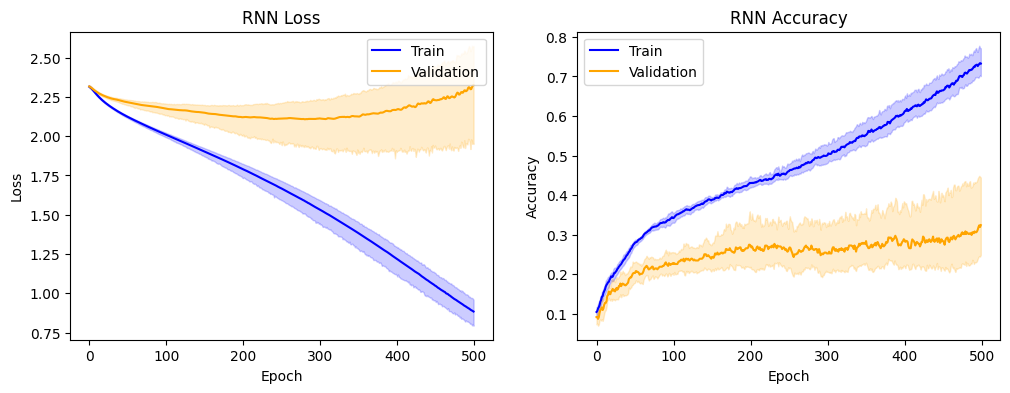

In [36]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories)

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
